### Paxillin movie segmentation and object feature analysis

with Patrick's 2D fixed image pFAK and Zyxin

Liya Ding, 2024.04

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage.morphology import binary_opening, binary_closing, binary_dilation
from skimage.morphology import disk


from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
from scipy import ndimage as ndi

In [3]:
image_2D_2CH_dir =  '/mnt/d/lding/zyxin/data/240423_fixed_EGFP_zyxin_pFAK/Control_images'

csv_output_dir = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/Control_pfak/Vessp555-LocLThrk1_dot_onecell_csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/Control_pfak/Vessp555-LocLThrk1_dot_onecell_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/Control_pfak/Vessp555-LocLThrk1_dot_onecell_seg'

pixel_size = 0.0706
time_point = 0

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

In [4]:
# build the colormap with iterative tab10
tab10 = cm.get_cmap('tab10', 10)
for i in range(10):
    tab10.colors = np.concatenate([tab10.colors,tab10.colors],axis=0)    
tab10.colors = np.concatenate([np.zeros([1,4]),tab10.colors],axis=0)

newmap = cm.get_cmap('tab10', 4000+1)
newmap.colors = tab10.colors[0:4000+1,:]
newmap.colors[0,:]  = np.zeros([1,4])
newmap.colors[0,3] = 1

### for each 3D stack run through MIP and 8th frame

In [5]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = True
flag_seg_save = True
flag_csv_save = True
flag_run_all = False
flag_panel_plot = True

In [6]:
# get a global intensity threshold 
filenames = [x for x in os.listdir(image_2D_2CH_dir) if os.path.isfile(os.path.join(image_2D_2CH_dir, x)) and ('.tif' in x)]

for filenameID in range(len(filenames)):
    filename = filenames[filenameID]
    # print(filename)
    img = tifffile.imread(os.path.join(image_2D_2CH_dir,filename))
    pax_img = img[1,:,:]
    zyxin_img = img[0,:,:]
    
    intensity_scaling_param = [5,20]
    norm_pax_img = intensity_normalization(pax_img, scaling_param=intensity_scaling_param)
    norm_zyxin_img = intensity_normalization(zyxin_img, scaling_param=intensity_scaling_param)
       
    MIP_pax_img = norm_pax_img
    MIP_zyxin_img = norm_zyxin_img

    smooth_MIP_zyxin_img = gaussian_filter(MIP_zyxin_img,sigma=4,mode='nearest',truncate=3)
    ### low threshold to get cell masks
    new_cell_mask = smooth_MIP_zyxin_img>0.02
    ### remove isolated small objects (small regions due to noise)
    new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=10000, connectivity=1, in_place=False)        
    # remove holes
    new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)

    if filenameID ==0:
        all_pax_img = np.zeros([len(filenames),pax_img.shape[0],pax_img.shape[1]])
        all_actin_img = np.zeros([len(filenames),pax_img.shape[0],pax_img.shape[1]])
        all_cell_mask = np.zeros([len(filenames),pax_img.shape[0],pax_img.shape[1]])
    all_pax_img[filenameID,:,:] = pax_img
    all_actin_img[filenameID,:,:] = zyxin_img
    all_cell_mask[filenameID,:,:] = new_cell_mask

    
global_pax_threshold  = all_pax_img[all_cell_mask>0].mean() + 1*all_pax_img[all_cell_mask>0].std()
global_zyxin_threshold  = all_actin_img[all_cell_mask>0].mean() + 1*all_actin_img[all_cell_mask>0].std()

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.


In [7]:
global_pax_threshold

137.51413217548162

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more details. Please use out argument instead.
/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/utils/utils.py:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a[index]
/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:99: FutureWarning: in_place argument is deprecated and will be removed in version 1.0. To avoid this warning, please do not use the in_place argument. Please see remove_small_objects documentation for more deta

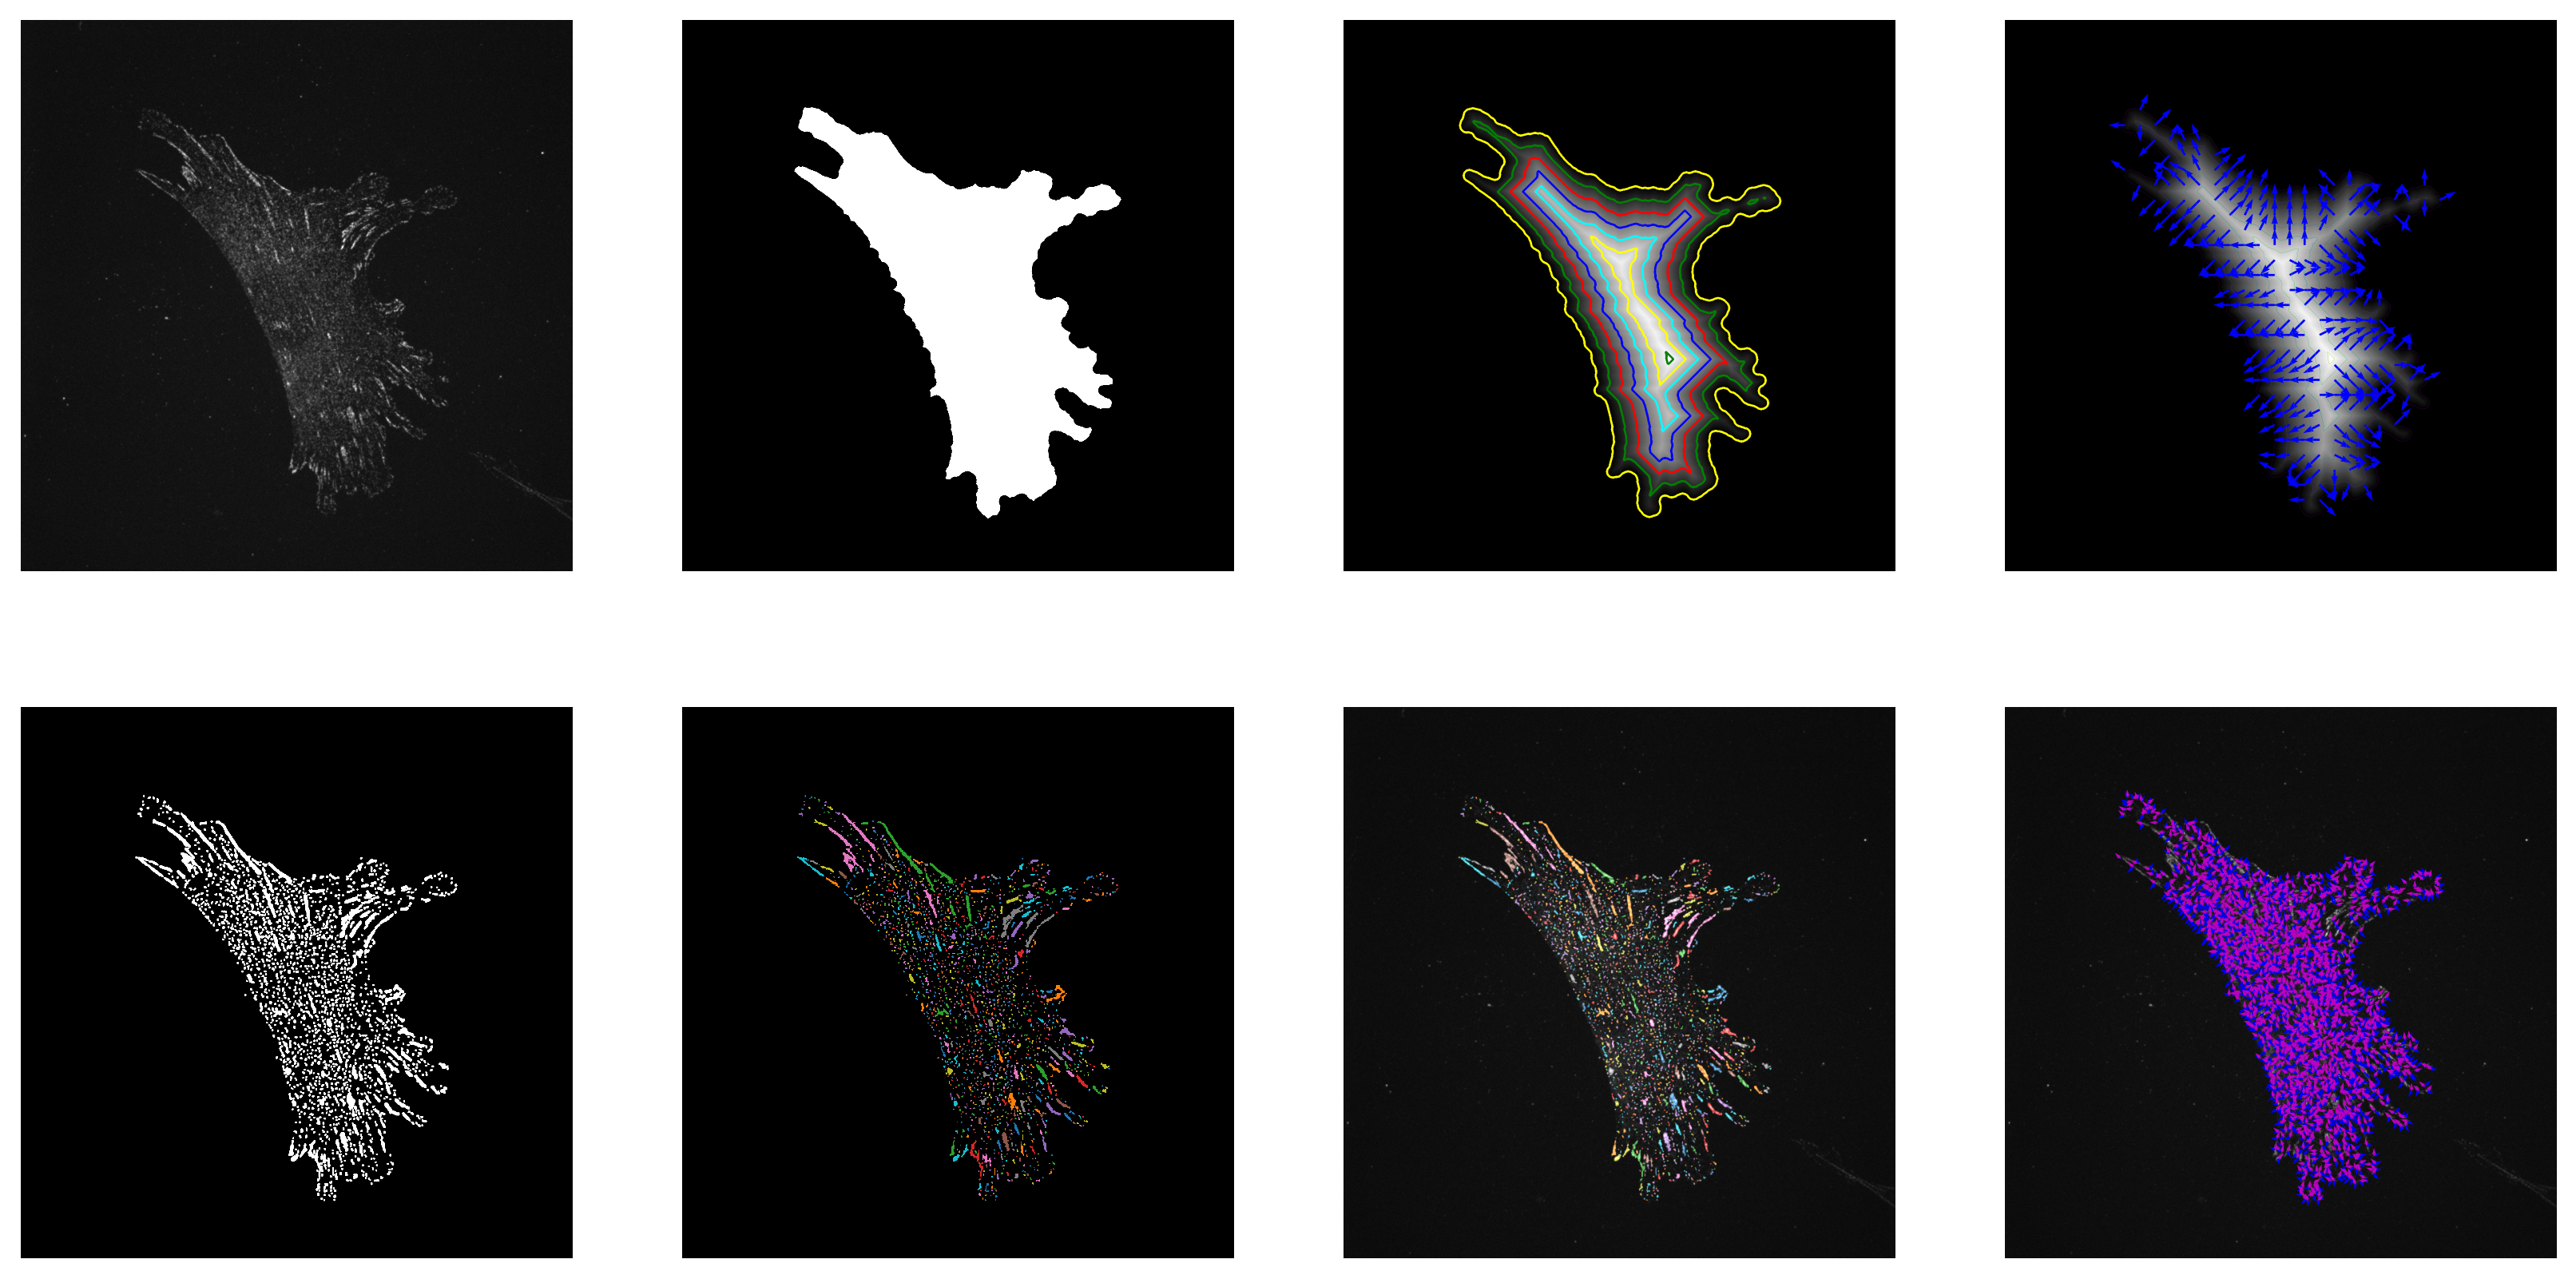

In [12]:
### for each movie, make sub-folders for different output for easier viewing in imagej
movie_mask_output_dir = os.path.join(seg_output_dir,  'mask')
movie_seg_output_dir = os.path.join(seg_output_dir,  'seg')
movie_label_output_dir = os.path.join(seg_output_dir,  'label')
movie_labeltoggle_output_dir = os.path.join(seg_output_dir,  'togglelabel')
movie_rgb_output_dir = os.path.join(seg_output_dir,  'rgb')    
movie_contour_output_dir = os.path.join(plot_output_dir,  'contour')
movie_quiver_cell_output_dir = os.path.join(plot_output_dir,  'quiver_cell')
movie_quiver_obj_output_dir = os.path.join(plot_output_dir,  'quiver_obj')
movie_label_color_output_dir = os.path.join(plot_output_dir,  'label_color')
movie_rgb_plot_output_dir = os.path.join(plot_output_dir,  'rgb_plot')
movie_panels_plot_output_dir = os.path.join(plot_output_dir,  'panel_plot')
movie_cluster_plot_output_dir = os.path.join(plot_output_dir,  'cluster_plot')

if not os.path.isdir(movie_labeltoggle_output_dir):   os.makedirs(movie_labeltoggle_output_dir)
if not os.path.isdir(movie_mask_output_dir):          os.makedirs(movie_mask_output_dir)
if not os.path.isdir(movie_seg_output_dir):           os.makedirs(movie_seg_output_dir)
if not os.path.isdir(movie_label_output_dir):         os.makedirs(movie_label_output_dir)
if not os.path.isdir(movie_rgb_output_dir):           os.makedirs(movie_rgb_output_dir)
if not os.path.isdir(movie_contour_output_dir):       os.makedirs(movie_contour_output_dir)
if not os.path.isdir(movie_quiver_cell_output_dir):   os.makedirs(movie_quiver_cell_output_dir)
if not os.path.isdir(movie_quiver_obj_output_dir):    os.makedirs(movie_quiver_obj_output_dir)
if not os.path.isdir(movie_label_color_output_dir):   os.makedirs(movie_label_color_output_dir)
if not os.path.isdir(movie_rgb_plot_output_dir):      os.makedirs(movie_rgb_plot_output_dir)
if not os.path.isdir(movie_panels_plot_output_dir):   os.makedirs(movie_panels_plot_output_dir)
# if not os.path.isdir(movie_cluster_plot_output_dir):   os.makedirs(movie_panels_plot_output_dir)
    

filenames = [x for x in os.listdir(image_2D_2CH_dir) if os.path.isfile(os.path.join(image_2D_2CH_dir, x)) and ('.tif' in x)]

# if not in run all mode, only test with the first image of the first movie
if not flag_run_all:
    filenames = filenames[56:57]

for filenameID in range(len(filenames)):
    prop_df_pax = pd.DataFrame(columns=['filename','cell_ID','time_point','pixel_size','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                    'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                    'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                    'cell_edge_dist','cell_edge_orient','diff_orient','zyxin_int'])

    
    filename = filenames[filenameID]
    img = tifffile.imread(os.path.join(image_2D_2CH_dir,filename))
    pax_img = img[1,:,:]
    zyxin_img = img[0,:,:]
    
    intensity_scaling_param = [10,40]
    norm_pax_img = intensity_normalization(pax_img, scaling_param=intensity_scaling_param)
    MIP_pax_img = norm_pax_img

    norm_zyxin_img = intensity_normalization(zyxin_img, scaling_param=intensity_scaling_param)    
         
    smooth_MIP_zyxin_img = gaussian_filter(zyxin_img,sigma=2,mode='nearest',truncate=3)


    smooth_MIP_pax_img = gaussian_filter(MIP_pax_img,sigma=1,mode='nearest',truncate=3)
    input_pax_img = MIP_pax_img

    ### low threshold to get cell masks
    new_cell_mask_zyxin = smooth_MIP_zyxin_img>103
    # new_cell_mask = np.logical_or(smooth_MIP_zyxin_img>103, smooth_MIP_pax_img>0.06)
    new_cell_mask_pfak = smooth_MIP_pax_img>0.07

    new_cell_mask = np.logical_or(new_cell_mask_pfak, new_cell_mask_zyxin)

    ### remove isolated small objects (small regions due to noise)
    new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=10000, connectivity=1, in_place=False)     
    new_cell_mask = binary_closing(new_cell_mask, disk(11))    

    # remove holes
    new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)
    # calculate the distance map

    distance_taxicab = distance_transform_cdt(new_cell_mask, metric="taxicab")

    smooth_MIP_pax_img = gaussian_filter(MIP_pax_img,sigma=1,mode='nearest',truncate=3)
    input_pax_img = MIP_pax_img
    ## PARAMETERS for vesselness filter step ##
    
    no_back_smooth_MIP_pax_img = smooth_MIP_pax_img.copy()
    no_back_smooth_MIP_pax_img[new_cell_mask==0] = np.mean(smooth_MIP_pax_img[new_cell_mask==1])
    thresh_sauvola = threshold_sauvola(no_back_smooth_MIP_pax_img, window_size=201,k=-1.0)
    binary_sauvola = MIP_pax_img > thresh_sauvola

    f2_param = [[3, 0.5]]
    pax_res_3 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)

    f2_param = [[2, 0.5]]
    pax_res_2 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)


    f2_param = [[1, 0.5]]
    pax_res_1 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)

    pax_seg_1 = pax_res_1 > 0.5
    pax_seg_2 = pax_res_2 > 0.5
    pax_seg_3 = pax_res_3 > 0.5

    binary_sauvola = remove_small_objects(binary_sauvola>0, min_size=5, connectivity=1, in_place=False)

    
    log_sigma = 1

    responce = -1*(log_sigma**2)*ndi.filters.gaussian_laplace(smooth_MIP_pax_img, log_sigma)
    
    pax_seg_dot = responce  > 0.012
    pax_seg_dot = remove_small_objects(pax_seg_dot>0, min_size=5, connectivity=1, in_place=False)

    pax_seg = (pax_seg_dot+ pax_seg_1 + pax_seg_2 + pax_seg_3 + binary_sauvola)>0    

    # remove segmentation outside of the cell
    pax_seg = pax_seg*new_cell_mask

    # remove pixels have intensity lower than global threshold of paxillin
    # pax_seg = pax_seg*(pax_img>global_pax_threshold)

    # remove single pixel objects
    pax_seg = remove_small_objects(pax_seg>0, min_size=5, connectivity=1, in_place=False)

    # label segmentations and calculate the region properties
    label_pax_seg = label(pax_seg)
    regionprops_pax = regionprops(label_pax_seg,intensity_image=input_pax_img)
        
    # prepare the color map with max of the labels for display (consistent through all images)
    pax_image_label_overlay = label2rgb(label_pax_seg, image=input_pax_img*4,kind='overlay',alpha=0.75,colors=newmap.colors)
    

    for_orent_mask = binary_opening(new_cell_mask, disk(11))
    for_orent_distance_taxicab = distance_transform_cdt(for_orent_mask, metric="taxicab")

    bigger_for_orent_mask = binary_dilation(for_orent_mask, disk(11))
    bigger_for_orent_distance_taxicab = distance_transform_cdt(bigger_for_orent_mask, metric="taxicab")


    # obtain cell edge orientation based on gradient of the distance map    
    n_v = skimage.filters.sobel_v(bigger_for_orent_distance_taxicab)
    n_h = skimage.filters.sobel_h(bigger_for_orent_distance_taxicab)
    # somehow the gradients are really small, make them reasonable values
    for_plot_max = 5/min(n_v.max(), n_h.max())
    n_v = n_v*for_plot_max
    n_h = n_h*for_plot_max
            
    # convert the directions into orientation angels   
    local_orientation = np.arctan2(n_v,n_h)

    # find the orentation and directional vectors for each object at the centroid        
    # initialize the vectors
    obj_X = np.zeros([label_pax_seg.max(),1])
    obj_Y = np.zeros([label_pax_seg.max(),1])
    cell_U = np.zeros([label_pax_seg.max(),1])
    cell_V = np.zeros([label_pax_seg.max(),1])
    obj_U = np.zeros([label_pax_seg.max(),1])
    obj_V = np.zeros([label_pax_seg.max(),1])
    cell_tan_U = np.zeros([label_pax_seg.max(),1])
    cell_tan_V = np.zeros([label_pax_seg.max(),1])
    
    for iL in range(label_pax_seg.max()):  
        zyxin_intensity_set = norm_zyxin_img[label_pax_seg==iL]

        obj_X[iL] = regionprops_pax[iL]['centroid'][0]
        obj_Y[iL] = regionprops_pax[iL]['centroid'][1]

        obj_U[iL] = np.sin(regionprops_pax[iL]['orientation'])
        obj_V[iL] = np.cos(regionprops_pax[iL]['orientation'])

        cell_edge_orient = local_orientation[int(obj_X[iL]),int(obj_Y[iL])]
        cell_tan_U[iL] = np.sin(cell_edge_orient)
        cell_tan_V[iL] = np.cos(cell_edge_orient)
        
        cell_U[iL] = n_v[int(obj_X[iL]),int(obj_Y[iL])]
        cell_V[iL] = n_h[int(obj_X[iL]),int(obj_Y[iL])]

        diff_orient = cell_edge_orient - regionprops_pax[iL]['orientation']

        if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
        if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
        if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi
        if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi

        diff_orient = np.abs(diff_orient)   

        cell_edge_dist = distance_taxicab[int(obj_X[iL]),int(obj_Y[iL])]

        X, Y = np.meshgrid(np.arange(0,new_cell_mask.shape[1]), np.arange(0,new_cell_mask.shape[0]))
        # build a sparse grid and only within cell mask for quivering the directions
        grid_mask = np.zeros_like(new_cell_mask)
        grid_mask[::30,::30] = new_cell_mask[::30,::30]
        to_plot_X = X[grid_mask>0]
        to_plot_Y = Y[grid_mask>0]
        to_plot_U = n_v[grid_mask>0]
        to_plot_H = n_h[grid_mask>0]

        # append the feature properties and add the distance and orientation features         
        s = pd.Series([filename, filenameID, time_point,pixel_size,
                        regionprops_pax[iL].area,regionprops_pax[iL].bbox_area,regionprops_pax[iL].convex_area,
                        regionprops_pax[iL].eccentricity,regionprops_pax[iL].equivalent_diameter,regionprops_pax[iL].euler_number,
                        regionprops_pax[iL].extent,regionprops_pax[iL].filled_area,regionprops_pax[iL].label,
                        regionprops_pax[iL].major_axis_length,regionprops_pax[iL].max_intensity,regionprops_pax[iL].mean_intensity,
                        regionprops_pax[iL].min_intensity,regionprops_pax[iL].minor_axis_length,regionprops_pax[iL].orientation,
                        regionprops_pax[iL].perimeter,regionprops_pax[iL].solidity, 
                        cell_edge_dist, cell_edge_orient,diff_orient, zyxin_intensity_set.mean()],
                        index=['filename','cell_ID','time_point','pixel_size','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                                'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                                'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                                'cell_edge_dist','cell_edge_orient','diff_orient','zyxin_int'])
        prop_df_pax = prop_df_pax.append(s,ignore_index=True)

    if flag_csv_save:
        prop_df_pax.to_csv(os.path.join(csv_output_dir,'labelprop_SS_'+filename+'_MIP'+'.csv'))

    if flag_seg_save:
        tifffile.imsave(os.path.join(movie_labeltoggle_output_dir, 'SS_pax_img_'+filename+'_MIP'+'.tif'),input_pax_img.astype(np.float32))   
        tifffile.imsave(os.path.join(movie_mask_output_dir, 'SS_cell_mask_'+filename+'_MIP'+'.tif'),new_cell_mask.astype(np.uint8))   
        tifffile.imsave(os.path.join(movie_seg_output_dir, 'SS_pax_seg_'+filename+'_MIP'+'.tif'),pax_seg.astype(np.uint8))   
        tifffile.imsave(os.path.join(movie_label_output_dir, 'SS_pax_seglabel_'+filename+'_MIP'+'.tif'),label_pax_seg.astype(np.uint16))   
        tifffile.imsave(os.path.join(movie_rgb_output_dir, 'SS_pax_segrgb_'+filename+'_MIP'+'.jpg'),pax_image_label_overlay)   
        # toggle_ch_overlay = np.zeros([1,2,label_pax_seg.shape[0],label_pax_seg.shape[1]])
        # toggle_ch_overlay[0,0,:,:] = label_pax_seg
        # toggle_ch_overlay[0,1,:,:] = input_pax_img
        # tifffile.imsave(os.path.join(movie_rgb_output_dir, 'SS_pax_seglabel_'+filename+'_MIP'+'.tif'),toggle_ch_overlay)   
        
    
    if flag_plot:
        if flag_panel_plot:
            # plot the main outputs together for quick viewing
            fig, ax = plt.subplots(2,4, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
            ax[0,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=0.8,vmin=0)
            ax[0,0].axis('off')
            ax[0,1].imshow(new_cell_mask, cmap=plt.cm.gray,vmax=0.3,vmin=0)
            ax[0,1].axis('off')

            # build a grid for contour plot

            ax[0,2].imshow(for_orent_distance_taxicab,cmap=plt.cm.gray)
            ax[0,2].contour(X, Y, for_orent_distance_taxicab,6,colors=('yellow','green', 'r','blue','cyan'),linewidths=0.7)
            ax[0,2].axis('off')        
        
            ax[0,3].imshow(for_orent_distance_taxicab,cmap=plt.cm.gray)
            ax[0,3].quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
            ax[0,3].contour(X, Y, for_orent_distance_taxicab,6,linewidths=0.1)    
            ax[0,3].axis('off')


            ax[1,0].imshow(pax_seg, cmap=plt.cm.gray,vmax=0.1,vmin=0)
            ax[1,0].axis('off')
            
            ax[1,1].imshow(label_pax_seg, cmap=newmap,interpolation='none',vmax = 4001,vmin = 0)
            ax[1,1].axis('off')

            ax[1,2].imshow(pax_image_label_overlay)
            ax[1,2].axis('off')
            
            ax[1,3].imshow(input_pax_img,cmap=plt.cm.gray,vmax=1,vmin=0)
            # quiver the orientation based on cell shape in blue
            ax[1,3].quiver(obj_Y,obj_X, -cell_U,cell_V,color='blue')
            # quiver the orientation of each object in magenta        
            ax[1,3].quiver(obj_Y,obj_X,  -obj_U,obj_V,color='m')         
            ax[1,3].axis('off')

            if flag_plot_save: 
                # save the plots and subplots for easier viewing
                plt.savefig(os.path.join(movie_panels_plot_output_dir,'panels_'+filename+'_MIP'+'_org_sm_ves_seg.png'))

                extent = ax[1,3].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join(movie_quiver_obj_output_dir,'quiver_obj_'+filename+'_MIP'+'.png'), bbox_inches=extent)

                extent = ax[0,2].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join(movie_contour_output_dir,'contours_'+filename+'_MIP'+'.png'), bbox_inches=extent)

                extent = ax[0,3].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join(movie_quiver_cell_output_dir,'quiver_cell_'+filename+'_MIP'+'.png'), bbox_inches=extent)

                extent = ax[1,1].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join(movie_label_color_output_dir,'labels_'+filename+'_MIP'+'.png'), bbox_inches=extent)

                extent = ax[1,2].get_tightbbox(fig.canvas.renderer).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(os.path.join(movie_rgb_plot_output_dir,'rgb_'+filename+'_MIP'+'.png'), bbox_inches=extent)
            
            if flag_run_all:
                plt.close(fig) 
        else:
            # plot the the features for debugging
            plt.rcParams["figure.figsize"] = (30,30)
            plt.imshow(input_pax_img*1.5,cmap=plt.cm.gray,vmax=1,vmin=0)
            # plt.hold(True)
            # quiver the orientation based on cell shape in blue

            for iL in range(1,label_pax_seg.max()):  

                obj_X[iL] = regionprops_pax[iL]['centroid'][0]
                obj_Y[iL] = regionprops_pax[iL]['centroid'][1]

                cell_edge_dist = distance_taxicab[int(obj_X[iL]),int(obj_Y[iL])]

                obj_U[iL] = np.sin(regionprops_pax[iL]['orientation'])
                obj_V[iL] = np.cos(regionprops_pax[iL]['orientation'])

                cell_edge_orient = local_orientation[int(obj_X[iL]),int(obj_Y[iL])]
                cell_tan_U[iL] = np.sin(cell_edge_orient)
                cell_tan_V[iL] = np.cos(cell_edge_orient)
                
                cell_U[iL] = n_v[int(obj_X[iL]),int(obj_Y[iL])]
                cell_V[iL] = n_h[int(obj_X[iL]),int(obj_Y[iL])]

                diff_orient = cell_edge_orient - regionprops_pax[iL]['orientation']
                if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
                if(diff_orient>np.pi/2):       diff_orient = diff_orient - np.pi
                if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi
                if(diff_orient<-np.pi/2):      diff_orient = diff_orient + np.pi

                diff_orient = np.abs(diff_orient)  
                [px,py] =np.where(label_pax_seg==iL)
                plt.plot(py,px,color=newmap.colors[iL,:])

                # plt.text(obj_Y[iL],obj_X[iL],'d='+f'{cell_edge_dist:.0f}'+',oo='+f'{regionprops_pax[iL].orientation:.1f}'+',co='+f'{cell_edge_orient:.1f}'+',diff='+f'{diff_orient:.1f}',color='r')
                plt.text(obj_Y[iL],obj_X[iL],'d'+f'{cell_edge_dist:.0f}'+',o'+f'{regionprops_pax[iL].orientation:.1f}'+',c'+f'{cell_edge_orient:.1f}'+',d'+f'{diff_orient:.1f}',color='r')
            
            plt.quiver(obj_Y,obj_X, -cell_U,cell_V,color='blue',width=0.001)
            # quiver the orientation of each object in magenta        
            plt.quiver(obj_Y,obj_X,  -obj_U,obj_V,color='m',width=0.001)   
            
            if flag_plot_save: 
                # save the plots and subplots for easier viewing
                plt.savefig(os.path.join(movie_panels_plot_output_dir,'features_'+filename+'_MIP'+'.png'))
            
            if flag_run_all:
                plt.close(fig) 
                    

                